# Introduction: Machine Learning Project Part

В этом проекте мы проходим через полную проблему машинного обучения, связанную с набором данных реального мира. Используя данные об энергии здания, мы пытаемся построить модель для прогнозирования показателя Energy Star в здании, что делает эту задачу контролируемой регрессией, задачей машинного обучения.

В первых двух частях этого проекта мы реализовали первые 6 шагов конвейера машинного обучения:

Очистка и форматирование данных
Исследовательский анализ данных
Особенности разработки и выбора
Сравните несколько моделей машинного обучения по метрике производительности
Выполните настройку гиперпараметра на лучшей модели, чтобы оптимизировать ее для проблемы
Оцените лучшую модель на тестовом наборе
Интерпретировать результаты модели в максимально возможной степени
Сделайте выводы и напишите хорошо документированный отчет
В этой записной книжке мы сконцентрируемся на двух последних шагах и попытаемся заглянуть в черный ящик модели, которую мы построили. Мы знаем, является ли он точным, так как он может прогнозировать показатель Energy Star в пределах 9,1 балла от истинного значения, но как именно он делает прогнозы? Мы рассмотрим некоторые способы, чтобы попытаться понять машину повышения градиента, а затем сделаем выводы (я избавлю вас от необходимости писать отчет и вместо этого сделаю ссылку на заполненный мной отчет для компании, которая дала мне это задание в качестве экрана работы .)

### Imports
We will use a familiar stack of data science and machine learning libraries.

In [24]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import  MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

from sklearn import tree
from sklearn.impute import SimpleImputer
# LIME for explaining predictions

import lime 
import lime.lime_tabular

In [6]:
# Read in data into dataframes 
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')
train_labels = pd.read_csv('training_labels.csv')
test_labels = pd.read_csv('testing_labels.csv')

## Recreate Final Model  Воссоздать финальную модель

In [10]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [11]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [12]:
model = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

model.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=6, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 9.0991


## Интерпретировать модель
Машинное обучение часто критикуют как черный ящик: мы помещаем данные с одной стороны, а это дает нам ответы с другой. Хотя эти ответы часто бывают чрезвычайно точными, модель ничего не говорит нам о том, как на самом деле делались прогнозы. В некоторой степени это верно, но есть способы, с помощью которых мы можем попытаться выяснить, как «мыслит» модель, такие как Локально интерпретируемый независимый от модели объяснитель (LIME). Это пытается объяснить предсказания модели, изучая линейную регрессию вокруг предсказания, которая является легко интерпретируемой моделью!

Мы рассмотрим несколько способов интерпретации нашей модели:

Особенности функций
Локально интерпретируемый модельно-независимый объяснитель (LIME)
Изучение единого дерева решений в ансамбле.

### Особенности Особенности
Один из основных способов интерпретации множества деревьев решений - это то, что известно как важность функций. Они могут быть интерпретированы как переменные, которые являются наиболее прогнозирующими для цели. Хотя фактические детали важности объектов довольно сложны (вот вопрос переполнения стека по теме, мы можем использовать относительные значения, чтобы сравнить функции и определить, какие из них наиболее актуальны для нашей проблемы.

Извлечь важность функций из обученного ансамбля деревьев довольно просто в scikit-learn. Мы будем хранить значения функций в кадре данных для их анализа и визуализации.

In [16]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(20)

,feature,importance
0,Site EUI (kBtu/ft²),0.449184
1,Weather Normalized Site Electricity Intensity ...,0.160424
2,Largest Property Use Type_Multifamily Housing,0.122771
3,Property Id,0.040509
4,DOF Gross Floor Area,0.032758
5,log_Direct GHG Emissions (Metric Tons CO2e),0.027738
6,Year Built,0.026747
7,Order,0.024467
8,log_Water Intensity (All Water Sources) (gal/ft²),0.023144
9,Census Tract,0.016952


Интенсивность использования энергии площадки, EUI площадки (кБту / фут²) и норма электричества площадки, нормализованная в зависимости от погоды, норма электричества площадки, нормализованная в погоде (кВтч / фут²), являются двумя наиболее важными характеристиками с довольно большим запасом. После этого относительная важность значительно падает, что указывает на то, что нам может не понадобиться сохранять все функции для создания модели с почти одинаковой производительностью.

Давайте наметим значения функций для визуального сравнения.

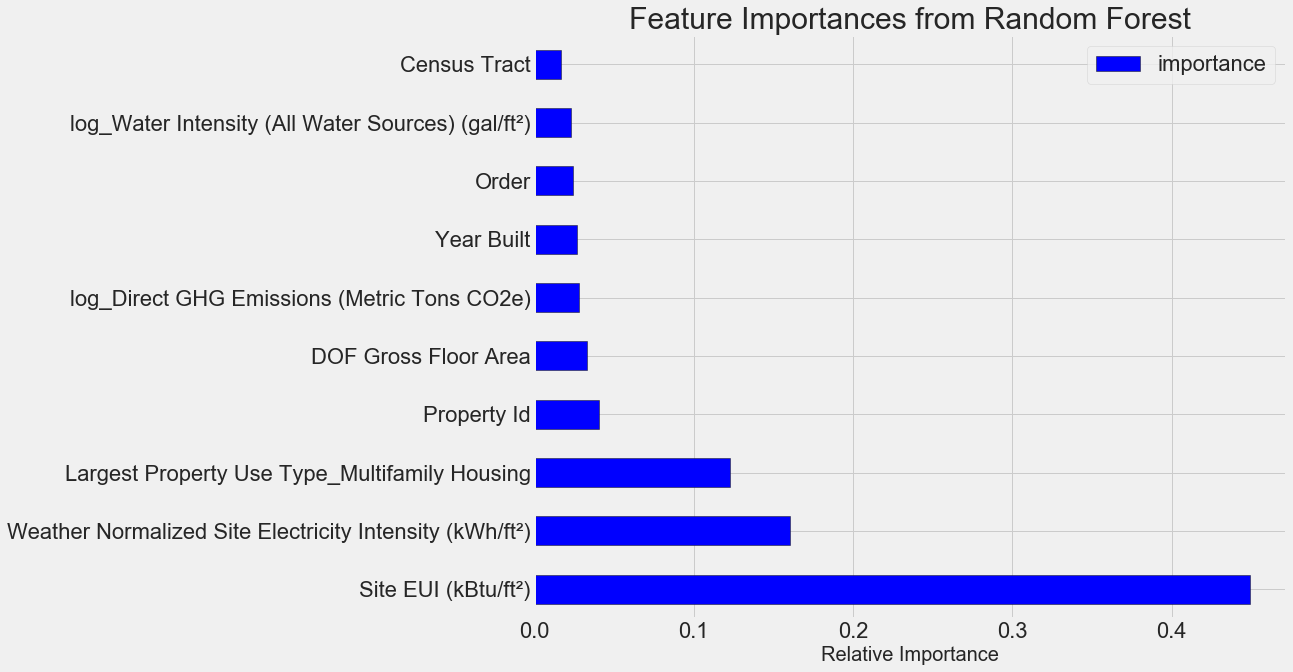

In [17]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

## Использовать значения функций для выбора функций
Учитывая, что не каждая функция важна для нахождения оценки, что произойдет, если мы используем более простую модель, такую как линейная регрессия, с подмножеством наиболее важных функций из случайного леса? Линейная регрессия действительно превзошла базовую линию, но она не показала хороших результатов по сравнению с моделями сложных моделей. Давайте попробуем использовать только 10 наиболее важных функций в линейной регрессии, чтобы увидеть, улучшается ли производительность. Мы также можем ограничиться этими функциями и переоценить случайный лес.

In [18]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6622, 10)
Most important testing  features shape:  (2839, 10)


In [20]:
lr = LinearRegression()

# Fit on full set of features
lr.fit(X, y)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    13.4901.
Linear Regression Reduced Results: MAE = 14.9258.


Ну, сокращение функций не улучшило результаты линейной регрессии! Оказывается, что дополнительная информация в функциях с низкой важностью действительно улучшает производительность.

Давайте посмотрим на использование сокращенного набора функций в регрессоре с градиентным усилением. Как влияет на производительность?

In [21]:
# Create the model with the same hyperparamters
model_reduced = GradientBoostingRegressor(loss='lad', max_depth=5, max_features=None,
                                  min_samples_leaf=6, min_samples_split=6, 
                                  n_estimators=800, random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Gradient Boosted Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Gradient Boosted Reduced Results: MAE = 9.6655


Результаты модели немного хуже с уменьшенным набором функций, и мы сохраним все функции для окончательной модели. Желание сократить количество функций связано с тем, что мы всегда стремимся создать наиболее экономную модель, то есть простейшую модель с адекватной производительностью. Модель, которая использует меньше функций, будет быстрее обучаться и, как правило, легче интерпретироваться. В этом случае сохранение всех функций не является серьезной проблемой, потому что время обучения не является значительным, и мы все еще можем делать интерпретации со многими функциями.

### Локально интерпретируемые модельно-независимые объяснения
Мы рассмотрим использование LIME для объяснения индивидуальных прогнозов, сделанных моделью. LIME - это относительно новое усилие, направленное на то, чтобы показать, как мыслит модель машинного обучения, аппроксимируя область вокруг прогноза линейной моделью.

Мы рассмотрим попытки объяснить прогнозы на примере, модель становится очень неправильной, а на примере модель - правильной. Мы ограничимся использованием сокращенного набора из 10 функций для облегчения интерпретации. Модель, обученная по 10 наиболее важным функциям, немного менее точна, но мы, как правило, должны поменять точность для интерпретации!

In [22]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [25]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y,
                                                   feature_names = list(most_important_features))

Prediction: 15.1501
Actual Value: 96.0000


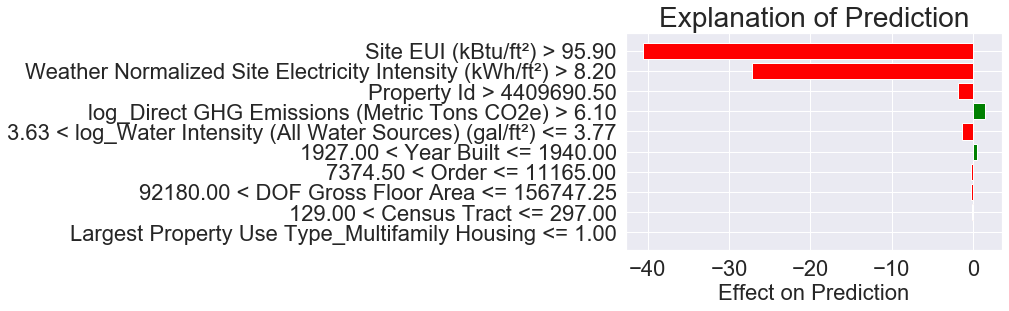

In [26]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [27]:
wrong_exp.show_in_notebook(show_predicted_value=False)

В этом примере наша модель с повышенным градиентом предсказала оценку 12,86, а фактическое значение было 100.

Сюжет из LIME показывает нам вклад в окончательный прогноз от каждой функции для примера. Мы видим, что сайт EUI заметно снизил прогноз, потому что он был выше 95,50. Погодная нормализованная интенсивность электричества на участке, с другой стороны, повысила прогноз, поскольку она была ниже 3,80.

Мы можем истолковать это как то, что наша модель считала, что показатель Energy Star будет намного ниже, чем на самом деле, потому что EUI сайта был высоким. Однако в этом случае оценка была 100, несмотря на высокое значение EUI. Хотя эта существенная ошибка (на 88 баллов!) Могла поначалу сбивать с толку, теперь мы можем видеть, что на самом деле модель размышляла над проблемой и просто достигла неверного значения! Человек, проходящий тот же процесс, вероятно, пришел бы к такому же выводу (если бы у него хватило терпения просмотреть все данные).

Теперь мы можем пройти тот же процесс с предсказанием, что модель оказалась правильной.

Prediction: 100.0000
Actual Value: 100.0000


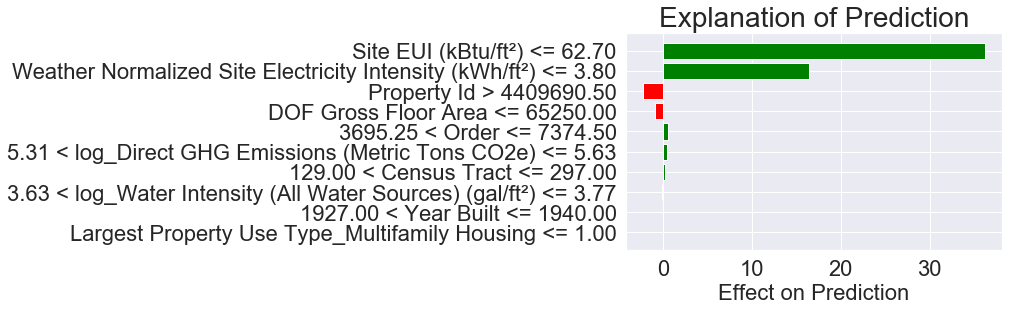

In [28]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [29]:
right_exp.show_in_notebook(show_predicted_value=False)

Правильное значение для этого случая было 100, что наша модель с усилением градиента получила право!

График из LIME снова показывает вклад в прогноз каждой из характерных переменных для примера. Например, поскольку показатель EUI на сайте был меньше 62,70, это значительно повысило оценку оценки. Аналогичным образом, год постройки, составивший менее 1927 года, также положительно повлиял на окончательный прогноз.

Наблюдение таких графиков позволяет нам получить представление о том, как модель делает прогноз. Это, вероятно, наиболее ценно для случаев, когда модель в значительной степени отключена, поскольку мы можем проверить ошибки и, возможно, разработать более совершенные функции или скорректировать гиперпараметры модели для улучшения прогнозов в следующий раз. Примеры, где модель больше не подходит, также могут быть интересными крайними случаями, которые нужно посмотреть вручную. Модель резко недооценила показатель Energy Star для первого здания из-за повышенной EUI на площадке. Поэтому мы могли бы спросить, почему у здания такой высокий показатель Energy Star, хотя у него такой высокий показатель EUI. Такой процесс, когда мы пытаемся работать с алгоритмом машинного обучения, чтобы понять проблему, кажется гораздо лучше, чем просто позволить модели делать предсказания и полностью доверять им! Хотя LIME не идеален, он представляет собой шаг в правильном направлении к объяснению

## Изучение единого дерева решений
Одна из самых классных частей ансамбля на основе дерева - это то, что мы можем взглянуть на любой отдельный оценщик. Хотя наша окончательная модель состоит из 800 деревьев решений, и рассмотрение одного из них не является показателем всей модели, она все же позволяет нам увидеть общее представление о том, как работает дерево решений. Отсюда естественно представить, как сотни этих деревьев строят ошибки предыдущих деревьев, чтобы сделать окончательный прогноз (это значительное упрощение того, как работает регрессия с повышением градиента!)

Сначала мы извлечем дерево из леса, а затем сохраним его с помощью sklearn.tree.export_graphviz. Это сохраняет дерево в виде файла .dot, который можно преобразовать в png с помощью инструкций командной строки в записной книжке.

In [33]:
# Extract a single tree
single_tree = model_reduced.estimators_[105][0]

tree.export_graphviz(single_tree, out_file = 'tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(ccp_alpha=0.0, criterion='friedman_mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=RandomState(MT19937) at 0x25D53EC7BF8,
                      splitter='best')

In [34]:
tree.export_graphviz(single_tree, out_file = 'tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 3)